In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd


def load_data():
    """Loads the CSV files and appends them into a single DataFrame"""
    column_types = {'Accident_Index': np.string_, 'LSOA_of_Accident_Location': np.string_}
    uk2015 = pd.read_csv("data/DfTRoadSafety_Accidents_2015.csv", dtype=column_types)
    uk2016 = pd.read_csv("data/dftRoadSafety_Accidents_2016.csv", dtype=column_types)
    return uk2015.append(uk2016)


In [2]:
from shapely.geometry import Point
from functools import partial
from shapely.ops import transform
import pyproj

def buffer_in_meters(lng, lat, radius):
    proj_meters = pyproj.Proj(init='epsg:3857')
    proj_latlng = pyproj.Proj(init='epsg:4326')
    
    project_to_meters = partial(pyproj.transform, proj_latlng, proj_meters)
    project_to_latlng = partial(pyproj.transform, proj_meters, proj_latlng)
    
    pt_latlng = Point(lng, lat)
    pt_meters = transform(project_to_meters, pt_latlng)
    
    buffer_meters = pt_meters.buffer(radius)
    buffer_latlng = transform(project_to_latlng, buffer_meters)
    return buffer_latlng

In [3]:
uk_acc = load_data()

In [4]:
uk_acc.dropna()

uk_acc = uk_acc.loc[uk_acc.Latitude <=  90.0]
uk_acc = uk_acc.loc[uk_acc.Latitude >= -90.0]

uk_acc = uk_acc.loc[uk_acc.Longitude <=  180.0]
uk_acc = uk_acc.loc[uk_acc.Longitude >= -180.0]

In [5]:
# Create the radian longitude and latitude columns
import math

uk_acc['rad_lng'] = uk_acc['Longitude'] * math.pi / 180.0
uk_acc['rad_lat'] = uk_acc['Latitude'] * math.pi / 180.0

In [21]:
# Parameters
eps_in_meters = 50.0
num_samples = 5

In [22]:
# Cluster the data
from sklearn.cluster import DBSCAN

earth_perimeter = 40070000.0  # In meters
eps_in_radians = eps_in_meters / earth_perimeter * (2 * math.pi)

uk_acc['cluster'] = DBSCAN(eps=eps_in_radians, min_samples=num_samples, metric='haversine').fit_predict(uk_acc[['rad_lat', 'rad_lng']])

In [23]:
uk_acc['cluster'].max()

5351

In [24]:
# Group the observations by cluster identifier
groups = uk_acc.groupby('cluster')

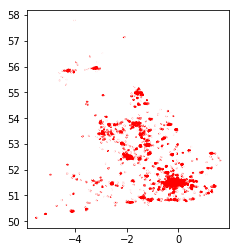

In [25]:
from shapely.ops import cascaded_union

clusters = list()
blobs = list()

for cluster_id, points in groups:
    if cluster_id >= 0:
        buffer_radius = eps_in_meters * 0.6
        buffers = [buffer_in_meters(lon, lat, buffer_radius) for lon, lat in zip(points['Longitude'].tolist(), points['Latitude'].tolist())]
        blob = cascaded_union(buffers)
        blobs.append(blob)
        clusters.append(cluster_id)
        
data = { 'cluster': clusters, 'polygon': blobs }

cluster_gdf = gpd.GeoDataFrame(pd.DataFrame(data), geometry='polygon')
cluster_gdf.crs = {'init': 'epsg:4326'}

ax = cluster_gdf.geometry.plot(linewidth=2.0, color='red', edgecolor='red')


In [26]:
import mplleaflet
mplleaflet.show(fig=ax.figure, tiles='cartodb_positron')